# Load Data
-   The data is collected from 2018, and the load types are categorized into three types: Light_Load, Medium_Load, and Maximum_Load.
-   The data is collected every 15 minutes, resulting in a total of 96 readings per day.
-   The data is split into training and testing sets, with the training set containing data from January to November and the testing set containing data from December.
-  The data contains various features such as Usage_kWh, Lagging_Current_Reactive.Power_kVarh, Leading_Current_Reactive_Power_kVarh, CO2(tCO2), Lagging_Current_Power_Factor, Leading_Current_Power_Factor, and Load_Type.
-   The data is cleaned by converting the Date_Time column to datetime format, extracting month and day information, and creating sinusoidal features for time series analysis.
-  Missing values are imputed using the mean of the respective month and Load_Type.
-   The data is then prepared for modeling by encoding the Load_Type and scaling the features using StandardScaler.
-  The data is split into training and testing sets, with the target variable being Load_Type.
-  Three different classifiers are trained on the data: Gradient Boosting Classifier, XGBoost Classifier, and LightGBM Classifier.
- The performance of each classifier is evaluated using accuracy, F1 score, and classification report.
- The results show that all classifiers perform well, with the LGBMClassifier achieving the highest F1 score (94.1%).
-   Accuracy: 0.9600268726906281
-   F1 Score: 0.9430656479406179

# Imports

In [67]:
import sklearn
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import holidays
import numpy as np

from seaborn import kdeplot
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
warnings.filterwarnings('always')
warnings.filterwarnings('once')
sns.set_style('darkgrid')
plt.style.use('dark_background')

In [68]:
df = pd.read_csv("data/load_data.csv")
df.head()

,Date_Time,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Load_Type
0,01-01-2018 00:15,8.753692,2.95,0.0,0.0,73.210000,100.0,900.000000,Light_Load
1,01-01-2018 00:30,4.000000,4.46,0.0,0.0,66.770000,100.0,1800.000000,Light_Load
2,01-01-2018 00:45,3.240000,3.28,0.0,0.0,70.280000,100.0,8070.880991,Light_Load
3,01-01-2018 01:00,3.310000,3.56,0.0,0.0,68.090000,100.0,3600.000000,Light_Load
4,01-01-2018 01:15,3.820000,4.50,0.0,0.0,133.655666,NaN,4500.000000,Light_Load


# Data Cleaning

In [69]:
df.isnull().sum()

Date_Time                                  0
Usage_kWh                               1559
Lagging_Current_Reactive.Power_kVarh     876
Leading_Current_Reactive_Power_kVarh    1156
CO2(tCO2)                                455
Lagging_Current_Power_Factor             350
Leading_Current_Power_Factor            1471
NSM                                      455
Load_Type                                  0
dtype: int64

In [70]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'], format="%d-%m-%Y %H:%M")

# train, text marking
df['train'] = 1
df.loc[df['Date_Time'].dt.month == 12, 'train' ] = 0

df.reset_index(drop=True)

,Date_Time,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Load_Type,train
0,2018-01-01 00:15:00,8.753692,2.95,0.000000,0.0,73.210000,100.00,900.000000,Light_Load,1
1,2018-01-01 00:30:00,4.000000,4.46,0.000000,0.0,66.770000,100.00,1800.000000,Light_Load,1
2,2018-01-01 00:45:00,3.240000,3.28,0.000000,0.0,70.280000,100.00,8070.880991,Light_Load,1
3,2018-01-01 01:00:00,3.310000,3.56,0.000000,0.0,68.090000,100.00,3600.000000,Light_Load,1
4,2018-01-01 01:15:00,3.820000,4.50,0.000000,0.0,133.655666,NaN,4500.000000,Light_Load,1
...,...,...,...,...,...,...,...,...,...,...
35036,2018-12-31 23:15:00,3.740000,3.74,0.000000,0.0,70.710000,100.00,83700.000000,Light_Load,0
35037,2018-12-31 23:30:00,3.780000,3.17,0.070000,0.0,76.620000,99.98,157160.395291,Light_Load,0
35038,2018-12-31 23:45:00,3.780000,3.06,0.110000,0.0,187.054285,99.96,85500.000000,Light_Load,0
35039,2018-12-31 00:00:00,3.670000,3.02,0.174801,0.0,77.220000,NaN,0.000000,Light_Load,0


### Create sinusoidal features for time series

In [71]:
class CFG:
    sinusol_hours = ['hour_sin', 'hour_cos', 'hour_sin 2t', 'hour_cos 2t', 'hour_sin 3t', 'hour_cos 3t','hour_sin 4t', 'hour_cos 4t', 'hour_sin t/2', 'hour_cos t/2']
    sinusol_months = ['month_sin', 'month_cos',]
    sinsols = [*sinusol_months, *sinusol_hours]

# convert Date_Time to datetime and extract month and day
df['month'] = df['Date_Time'].dt.month
df['daynum'] = (df.Date_Time - df.Date_Time.iloc[0]).dt.days
df['weekday'] = df.Date_Time.dt.weekday
# no need for year as all are from 2018
df['dayofmonth'] = df.Date_Time.dt.day
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['hour'] = df.Date_Time.dt.hour
df['hour_sin t/2'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos t/2'] = np.cos(2 * np.pi * df['hour'] / 24)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['hour_sin 2t'] = np.sin(4 * np.pi * df['hour'] / 24)
df['hour_cos 2t'] = np.cos(4 * np.pi * df['hour'] / 24)
df['hour_sin 3t'] = np.sin(6 * np.pi * df['hour'] / 24)
df['hour_cos 3t'] = np.cos(6 * np.pi * df['hour'] / 24)
df['hour_sin 4t'] = np.sin(8 * np.pi * df['hour'] / 24)
df['hour_cos 4t'] = np.cos(8 * np.pi * df['hour'] / 24)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
df

,Date_Time,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Load_Type,train,...,hour_sin,hour_cos,hour_sin 2t,hour_cos 2t,hour_sin 3t,hour_cos 3t,hour_sin 4t,hour_cos 4t,dayofweek_sin,dayofweek_cos
0,2018-01-01 00:15:00,8.753692,2.95,0.000000,0.0,73.210000,100.00,900.000000,Light_Load,1,...,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.0,0.0,1.0
1,2018-01-01 00:30:00,4.000000,4.46,0.000000,0.0,66.770000,100.00,1800.000000,Light_Load,1,...,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.0,0.0,1.0
2,2018-01-01 00:45:00,3.240000,3.28,0.000000,0.0,70.280000,100.00,8070.880991,Light_Load,1,...,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.0,0.0,1.0
3,2018-01-01 01:00:00,3.310000,3.56,0.000000,0.0,68.090000,100.00,3600.000000,Light_Load,1,...,0.258819,0.965926,0.500000,0.866025,7.071068e-01,0.707107,0.866025,0.5,0.0,1.0
4,2018-01-01 01:15:00,3.820000,4.50,0.000000,0.0,133.655666,NaN,4500.000000,Light_Load,1,...,0.258819,0.965926,0.500000,0.866025,7.071068e-01,0.707107,0.866025,0.5,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35036,2018-12-31 23:15:00,3.740000,3.74,0.000000,0.0,70.710000,100.00,83700.000000,Light_Load,0,...,-0.258819,0.965926,-0.500000,0.866025,-7.071068e-01,0.707107,-0.866025,0.5,0.0,1.0
35037,2018-12-31 23:30:00,3.780000,3.17,0.070000,0.0,76.620000,99.98,157160.395291,Light_Load,0,...,-0.258819,0.965926,-0.500000,0.866025,-7.071068e-01,0.707107,-0.866025,0.5,0.0,1.0
35038,2018-12-31 23:45:00,3.780000,3.06,0.110000,0.0,187.054285,99.96,85500.000000,Light_Load,0,...,-0.258819,0.965926,-0.500000,0.866025,-7.071068e-01,0.707107,-0.866025,0.5,0.0,1.0
35039,2018-12-31 00:00:00,3.670000,3.02,0.174801,0.0,77.220000,NaN,0.000000,Light_Load,0,...,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.0,0.0,1.0


# Impute missing values

In [72]:
usage_mean_per_month = df.groupby(['month', 'Load_Type'])['Usage_kWh'].mean().reset_index()
lag_curr_reactive_mean_per_month = df.groupby(['month', 'Load_Type'])['Lagging_Current_Reactive.Power_kVarh'].mean().reset_index()
lead_curr_reactive_mean_per_month = df.groupby(['month', 'Load_Type'])['Leading_Current_Reactive_Power_kVarh'].mean().reset_index()
co2_mean_per_month = df.groupby(['month', 'Load_Type'])['CO2(tCO2)'].mean().reset_index()
lagging_curr_pf_mean_per_month = df.groupby(['month', 'Load_Type'])['Lagging_Current_Power_Factor'].mean().reset_index()
leading_curr_pf_mean_per_month = df.groupby(['month', 'Load_Type'])['Leading_Current_Power_Factor'].mean().reset_index()

df['Usage_kWh'].fillna(df.merge(usage_mean_per_month, on=['month', 'Load_Type'], how='left')['Usage_kWh_y'], inplace=True)
df['Lagging_Current_Reactive.Power_kVarh'].fillna(df.merge(lag_curr_reactive_mean_per_month, on=['month', 'Load_Type'], how='left')['Lagging_Current_Reactive.Power_kVarh_y'], inplace=True)
df['Leading_Current_Reactive_Power_kVarh'].fillna(df.merge(lead_curr_reactive_mean_per_month, on=['month', 'Load_Type'], how='left')['Leading_Current_Reactive_Power_kVarh_y'], inplace=True)
df['CO2(tCO2)'].fillna(df.merge(co2_mean_per_month, on=['month', 'Load_Type'], how='left')['CO2(tCO2)_y'], inplace=True)
df['Lagging_Current_Power_Factor'].fillna(df.merge(lagging_curr_pf_mean_per_month, on=['month', 'Load_Type'], how='left')['Lagging_Current_Power_Factor_y'], inplace=True)
df['Leading_Current_Power_Factor'].fillna(df.merge(leading_curr_pf_mean_per_month, on=['month', 'Load_Type'], how='left')['Leading_Current_Power_Factor_y'], inplace=True)

df.drop(['NSM'], inplace=True, axis=1, errors='ignore')


df['total_reactive_power'] = df['Lagging_Current_Reactive.Power_kVarh'] + df['Leading_Current_Reactive_Power_kVarh']
df['power_factor_diff'] = df['Lagging_Current_Power_Factor'] - df['Leading_Current_Power_Factor']
df['reactive_usage_ratio'] = df['total_reactive_power'] / (df['Usage_kWh'] + 0.00001)

total_load_time_per_day = df['Load_Type']

/tmp/ipykernel_350710/3212174099.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Usage_kWh'].fillna(df.merge(usage_mean_per_month, on=['month', 'Load_Type'], how='left')['Usage_kWh_y'], inplace=True)
/tmp/ipykernel_350710/3212174099.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

# EDA

<Axes: xlabel='month'>

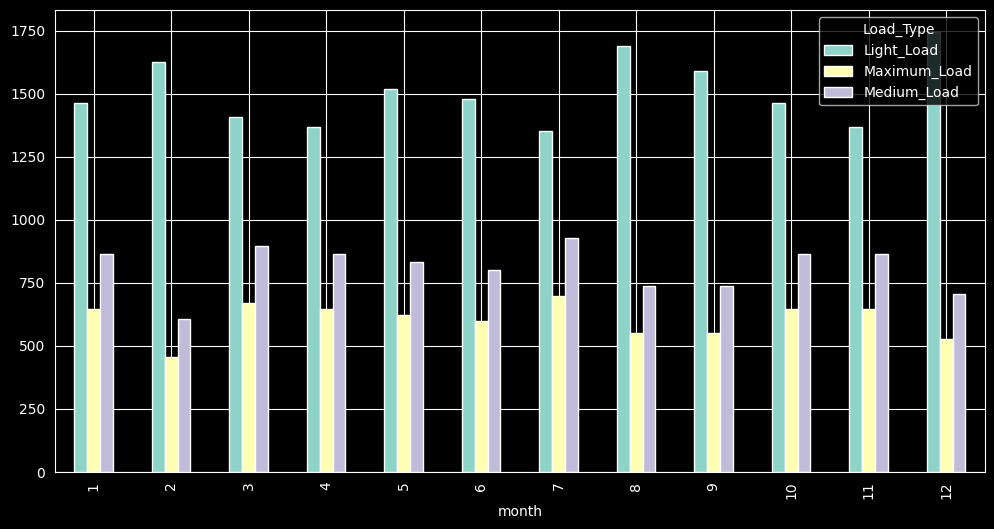

In [73]:
df.groupby('month')['Load_Type'].value_counts().unstack().plot(kind='bar', figsize=(12, 6))

In [74]:
load_count_per_day = df.groupby('daynum')['Load_Type'].value_counts().reset_index()
load_count_per_day['percent_a_day_y'] = load_count_per_day['count']*15 / (60*24)
load_count_per_day

,daynum,Load_Type,count,percent_a_day_y
0,-1,Light_Load,1,0.010417
1,0,Light_Load,96,1.000000
2,1,Light_Load,40,0.416667
3,1,Medium_Load,32,0.333333
4,1,Maximum_Load,24,0.250000
...,...,...,...,...
967,361,Medium_Load,32,0.333333
968,361,Maximum_Load,24,0.250000
969,362,Light_Load,96,1.000000
970,363,Light_Load,96,1.000000


In [75]:
df['load_percent_a_day'] = df.merge(load_count_per_day, on=['daynum', 'Load_Type'], how='left')['percent_a_day_y']
df.head()

,Date_Time,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,Load_Type,train,month,...,hour_sin 3t,hour_cos 3t,hour_sin 4t,hour_cos 4t,dayofweek_sin,dayofweek_cos,total_reactive_power,power_factor_diff,reactive_usage_ratio,load_percent_a_day
0,2018-01-01 00:15:00,8.753692,2.95,0.0,0.0,73.210000,100.000000,Light_Load,1,1,...,0.000000,1.000000,0.000000,1.0,0.0,1.0,2.95,-26.790000,0.337000,1.0
1,2018-01-01 00:30:00,4.000000,4.46,0.0,0.0,66.770000,100.000000,Light_Load,1,1,...,0.000000,1.000000,0.000000,1.0,0.0,1.0,4.46,-33.230000,1.114997,1.0
2,2018-01-01 00:45:00,3.240000,3.28,0.0,0.0,70.280000,100.000000,Light_Load,1,1,...,0.000000,1.000000,0.000000,1.0,0.0,1.0,3.28,-29.720000,1.012343,1.0
3,2018-01-01 01:00:00,3.310000,3.56,0.0,0.0,68.090000,100.000000,Light_Load,1,1,...,0.707107,0.707107,0.866025,0.5,0.0,1.0,3.56,-31.910000,1.075525,1.0
4,2018-01-01 01:15:00,3.820000,4.50,0.0,0.0,133.655666,98.841382,Light_Load,1,1,...,0.707107,0.707107,0.866025,0.5,0.0,1.0,4.50,34.814285,1.178007,1.0


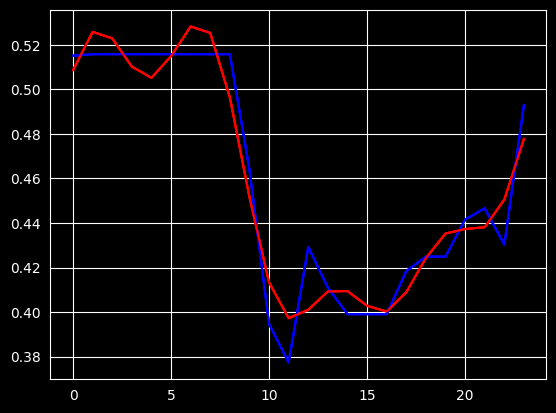

In [76]:
for load in df['Load_Type'].unique():
    abt = df.groupby('hour')
    x = abt[CFG.sinusol_hours].mean().to_numpy()
    y = abt['load_percent_a_day'].mean().to_numpy()

    reg = Ridge(alpha=0.1).fit(x, y)
    p = reg.predict(x)

    plt.plot(y, 'b')
    plt.plot(p, 'r')

plt.show()

In [77]:
# Create additional features (i.e. holidays, seasons, etc.)

df['isHoliday'] = 0
for holiday, _ in holidays.CountryHoliday('IND', years=2018).items():
    df.loc[(df.Date_Time.dt.day == holiday.day) & (df.Date_Time.dt.month == holiday.month), 'isHoliday'] = 1

season_map = {
    12: 1, 1:  1, 2:  1,  # Winter -> 1
    3:  2, 4:  2, 5:  2,  # Spring -> 2
    6:  3, 7:  3, 8:  3,  # Summer -> 3
    9:  4, 10: 4, 11: 4   # Fall -> 4
}
df['season'] = df['month'].map(season_map)

df['usage_hour_sin'] = df['Usage_kWh'] * df['hour_sin']
df['usage_hour_cos'] = df['Usage_kWh'] * df['hour_cos']

df['usage_rolling_mean_3h'] = df['Usage_kWh'].rolling(12).mean()# data in 15 min so -> 15 * 12
df['usage_rolling_mean_6h'] = df['Usage_kWh'].rolling(24).mean()
# drop the first NaN values
df.dropna(axis=0, inplace=True)

/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/holidays/utils.py:330: DeprecationWarning: CountryHoliday is deprecated, use country_holidays instead.
  warnings.warn(


In [78]:
df.drop(['day', 'load_factor', 'daynum', 'load_percent_a_day', 'month'], inplace=True, axis=1, errors='ignore')

In [79]:
df.columns

Index(['Date_Time', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor',
       'Load_Type', 'train', 'weekday', 'dayofmonth', 'month_sin', 'month_cos',
       'hour', 'hour_sin t/2', 'hour_cos t/2', 'hour_sin', 'hour_cos',
       'hour_sin 2t', 'hour_cos 2t', 'hour_sin 3t', 'hour_cos 3t',
       'hour_sin 4t', 'hour_cos 4t', 'dayofweek_sin', 'dayofweek_cos',
       'total_reactive_power', 'power_factor_diff', 'reactive_usage_ratio',
       'isHoliday', 'season', 'usage_hour_sin', 'usage_hour_cos',
       'usage_rolling_mean_3h', 'usage_rolling_mean_6h'],
      dtype='object')

# Encode Load_Type & Scale Features & Split Data

In [80]:
load_map = {
    'Light_Load': 0,
    'Medium_Load': 1,
    'Maximum_Load': 2
}
rev_load = {
    0: 'Light_Load',
    1: 'Medium_Load',
    2: 'Maximum_Load'
}

df['Load_Type'] = df['Load_Type'].map(load_map)
scalar = StandardScaler()

train = df[df['train'] == 1].drop('Date_Time',axis=1)
test = df[df['train'] == 0].drop('Date_Time', axis=1)
y_train = train['Load_Type']
x_train = train.drop(['Load_Type'], axis=1)
y_test = test['Load_Type']
x_test = test.drop(['Load_Type'], axis=1)

x_train_scaled = scalar.fit_transform(x_train)
x_test_scaled = scalar.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((32041, 33), (32041,), (2977, 33), (2977,))

# Gradient Boosting Classifier

In [81]:
gb_model = GradientBoostingClassifier(
    loss='log_loss',
    learning_rate=0.1,
    n_estimators=250,
    subsample=1.0,
    criterion='friedman_mse',
    min_samples_split=5,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=5,
    min_impurity_decrease=0.0,
    init=None,
    random_state=42,
    max_features=None,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=1e-4,
    ccp_alpha=0.0
)
gb_model.fit(x_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,250
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


In [82]:
def results(y_true, y_hat):
    print(f"Accuracy: {accuracy_score(y_true, y_hat)}")
    print(f"F1 Score: {f1_score(y_true, y_hat, average='macro')}")
    report = classification_report(y_true, y_hat)
    print(report)

results(y_test, gb_model.predict(x_test))

Accuracy: 0.958011420893517
F1 Score: 0.9391945872003243
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1745
           1       0.93      0.93      0.93       704
           2       0.94      0.87      0.90       528

    accuracy                           0.96      2977
   macro avg       0.95      0.93      0.94      2977
weighted avg       0.96      0.96      0.96      2977



# XGBoost Classifier

In [83]:
param_grid = {
    'max_depth': [7], # [3, 5, 7, 9],
    'min_child_weight': [5],# [1, 3, 5],
    'gamma': [0.3], # [0, 0.1, 0.3],
    'subsample': [1.0], # [0.8, 1.0],
    'colsample_bytree': [1.0], # [0.8, 1.0],
    'learning_rate': [0.1],
    'n_estimators': [50, 100, 300, 500],
    'scale_pos_weight': [1, 2, 3]  # especially if imbalanced
}

In [84]:
xgb_model = xgb.XGBClassifier()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/shrek/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/shrek/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/shrek/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resou

[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=50, scale_pos_weight=3, subsample=1.0; total time=   2.2s


/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=50, scale_pos_weight=2, subsample=1.0; total time=   2.9s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=50, scale_pos_weight=1, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=50, scale_pos_weight=2, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=50, scale_pos_weight=3, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=50, scale_pos_weight=1, subsample=1.0; total time=   3.0s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=50, scale_pos_weight=3, subsample=1.0; total time=   3.1s
[CV] END c

/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fo

[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   4.2s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.1s


/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.2s


/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, scale_pos_weight=1, subsample=1.0; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.2s
[CV]

/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fo


[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, scale_pos_weight=2, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, scale_pos_weight=3, subsample=1.0; total time=   2.4s


/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fo

[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, scale_pos_weight=1, subsample=1.0; total time=   3.9s


/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, scale_pos_weight=1, subsample=1.0; total time=   3.9s


/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, scale_pos_weight=1, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, scale_pos_weight=1, subsample=1.0; total time=   4.6s


/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, scale_pos_weight=1, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, scale_pos_weight=2, subsample=1.0; total time=   3.6s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, scale_pos_weight=2, subsample=1.0; total time=   3.9s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, scale_pos_weight=2, subsample=1.0; total time=   3.8s


/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, scale_pos_weight=2, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, scale_pos_weight=3, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, scale_pos_weight=2, subsample=1.0; total time=   4.0s


/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fo

[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, scale_pos_weight=3, subsample=1.0; total time=   4.0s


/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, scale_pos_weight=3, subsample=1.0; total time=   4.2s


/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, scale_pos_weight=3, subsample=1.0; total time=   4.4s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, scale_pos_weight=3, subsample=1.0; total time=   4.5s


/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=500, scale_pos_weight=1, subsample=1.0; total time=   5.4s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=500, scale_pos_weight=1, subsample=1.0; total time=   4.9s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=500, scale_pos_weight=1, subsample=1.0; total time=   4.8s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=500, scale_pos_weight=1, subsample=1.0; total time=   4.7s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=500, scale_pos_weight=2, subsample=1.0; total time=   4.6s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=500, scale_pos_weight=2, subsample=1.0; total time=   4.5s
[CV]

/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [1.0], 'gamma': [0.3], 'learning_rate': [0.1], 'max_depth': [7], ...}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softprob'


In [85]:
xgb_model = XGBClassifier(**grid_search.best_params_)
xgb_model.fit(x_train, y_train)

/home/shrek/Downloads/forcasting/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:25:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [86]:
results(y_test, xgb_model.predict(x_test))

Accuracy: 0.9583473295263688
F1 Score: 0.9395007503103994
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1745
           1       0.94      0.92      0.93       704
           2       0.92      0.89      0.90       528

    accuracy                           0.96      2977
   macro avg       0.95      0.93      0.94      2977
weighted avg       0.96      0.96      0.96      2977



# LightGBM Classifier

In [87]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=3,
    learning_rate=0.05,
    max_depth=7,
    n_estimators=300,
    subsample=1,
    colsample_bytree=0.9,
    class_weight='balanced',  # try this if imbalance exists
    random_state=42,
).fit(x_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3599
[LightGBM] [Info] Number of data points in the train set: 32041, number of used features: 32
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [88]:
results(y_test, lgbm.predict(x_test))

Accuracy: 0.9600268726906281
F1 Score: 0.9430656479406179
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1745
           1       0.94      0.93      0.93       704
           2       0.93      0.89      0.91       528

    accuracy                           0.96      2977
   macro avg       0.95      0.94      0.94      2977
weighted avg       0.96      0.96      0.96      2977



In [89]:
confusion_matrix(y_test, grid_search.predict(x_test))

array([[1737,    8,    0],
       [  17,  647,   40],
       [  23,   36,  469]])